In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import sys
from analysis_utils import *

In [11]:
VERSION = 'c2.1'
data = get_data(VERSION, '../experiment/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

# TRIALS = pd.read_json('../experiment/experiment/static/json/constant_high.json' ).set_index('trial_id').stateRewards

pdf = data['participants']
mdf = data['mouselab-mdp']
tdf = mdf.query('block == "test"').copy()

tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

tdf['clicks'] = tdf.queries.apply(extract)
tdf['n_clicks'] = tdf.clicks.apply(len)
pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.sum()

In [26]:
mdf['variance'] = pdf.variance

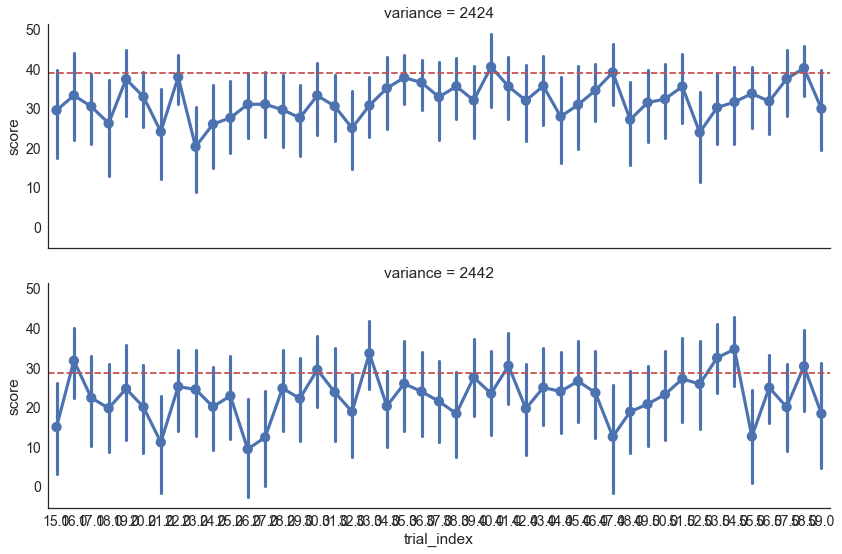

In [56]:
g = sns.factorplot('trial_index', 'score', data=mdf.query('trial_index >= 15'),
                   row='variance', aspect=3)
ax = g.axes.flat
ax[0].axhline(39.1, c='r', ls='--')
ax[1].axhline(28.8, c='r', ls='--')

In [66]:
mdf.query('trial_index >= 20').block

pid
0     train_inspect_cost
0     train_inspect_cost
0     train_inspect_cost
0     train_inspect_cost
0     train_inspect_cost
0            train_final
0            train_final
0            train_final
0            train_final
0            train_final
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
0                   test
             ...        
72                  test
72                  test
72                  test
72                  test
72                  test
72                  test
72                  test
72                  test
72                  t

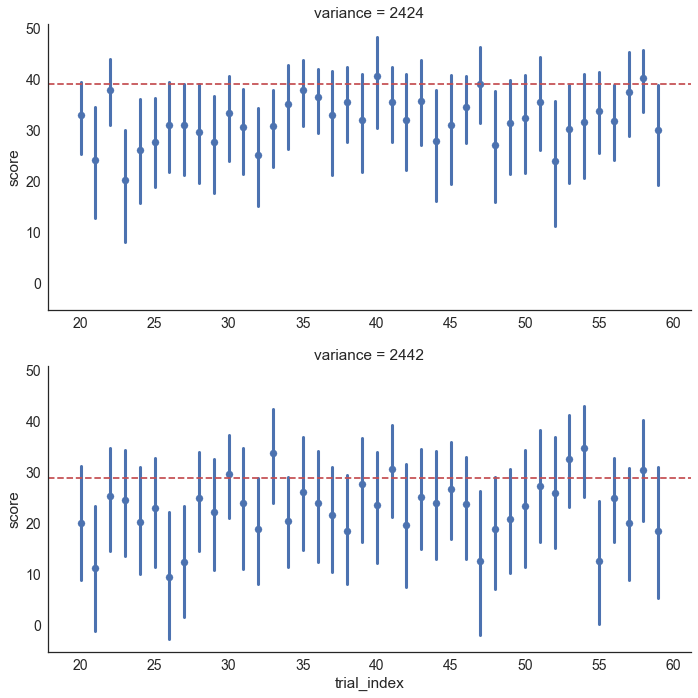

In [62]:
g = sns.lmplot('trial_index', 'score', data=mdf.query('trial_index >= 20'),
           x_bins=100, aspect=2, row='variance', fit_reg=0,
           sharex='none', truncate=True)

g.axes.flat[0].axhline(39.1, c='r', ls='--')
g.axes.flat[1].axhline(28.8, c='r', ls='--')

6.90  3.47  2.05


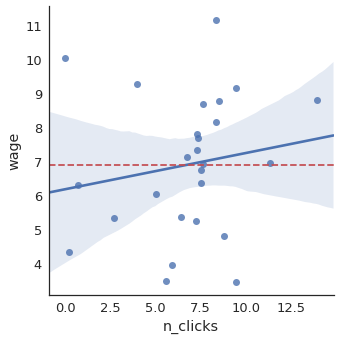

In [9]:
pdf['pay'] = (1 + pdf.bonus)
pdf['wage'] = pdf.pay / (pdf.total_time / 60)
print(f'{pdf.wage.mean():.2f}  {pdf.wage.min():.2f}  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

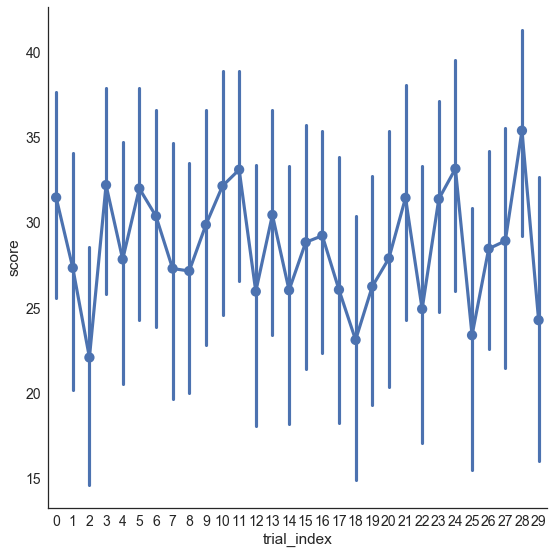

In [8]:
sns.factorplot('trial_index', 'score', data=tdf, size=8)

# Python stats

In [13]:
import statsmodels.formula.api as smf
model = smf.ols('score ~ trial_index', data=tdf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2739
Date:                Thu, 18 Jan 2018   Prob (F-statistic):              0.601
Time:                        22:59:34   Log-Likelihood:                -2506.6
No. Observations:                 520   AIC:                             5017.
Df Residuals:                     518   BIC:                             5026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      25.7907      2.541     10.151      0.000      20.799      30.782
trial_index    -0.1197      0.229     -0.523      0.601      -0.569       0.329
==============================================================================
Omnibus:                       23.216   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.111
Skew:                          -0.453   Prob(JB):                     1.30e-06
Kurtosis:                       3.657   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Test qualitative predictions

1. The first observed node is a stem node or branch node rather than a leaf node.
1. If the first observed node is a non-leaf and its revealed value is 8 or larger, then people should inspect a leaf node on the same branch. But if the value is -8 or smaller then they should inspect a non-leaf node on a different branch.
1. People should not stop collecting information until they either find a path with an expected return of at least 32 or have already inspected all nodes.
1. If two nodes lie on paths with similar expected value, then people should prefer to inspect the node that is informative about multiple paths (stem and branch nodes) over nodes that are informative about only a single path (leaf nodes).
1. Unless the observed non-leaf has a value of 24 or higher people should switch to a new branch after at most 2 observations on the first branch they looked at.

### Prediction 1: The first observed node is a stem node or branch node rather than a leaf node.


In [126]:
trial_ids = tdf['clicks'].keys()

first_click = np.array([])
second_click = np.array([])

first_observation = np.array([])

first_click_level = np.array([])
second_click_level = np.array([])

first_click_branch = np.array([])
second_click_branch = np.array([])

observed_value = np.array([])

stem_nodes = [1,5,9,13]
branch_nodes = [2,6,10,14]
leaf_nodes = [3,4,7,8,11,12,15,16]

nodes_by_depth=[stem_nodes,branch_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]

nr_clicks = np.array([])

for t in trial_ids:
    clicks = tdf['clicks'][t]
    if len(clicks)>0:
        first_click = np.append(first_click,[clicks[0]])
        
        for level in range(3):
            if np.isin(first_click[-1],nodes_by_depth[level]):
                first_click_level = np.append(first_click_level,level+1)

        for branch in range(4):
            if np.isin(first_click[-1],nodes_by_branch[branch]):
                first_click_branch = np.append(first_click_branch,branch+1)
                
        #todo: push the observed value
        trial_id = tdf['trial_id'][t]
        first_obs = TRIALS[trial_id][int(first_click[-1])]
        observed_value = np.append(observed_value,[first_obs])
        nr_clicks = np.append(nr_clicks,len(clicks))
        if len(clicks)>1:
            second_click = np.append(second_click,[clicks[1]])
            for level in range(3):
                if np.isin(second_click[-1],nodes_by_depth[level]):
                    second_click_level = np.append(second_click_level,level+1)
            
            for branch in range(4):
                if np.isin(second_click[-1],nodes_by_branch[branch]):
                    second_click_branch = np.append(second_click_branch,branch+1)

        else:
            second_click = np.append(second_click,[17])
            second_click_level = np.append(second_click_level,[0])
            second_click_branch = np.append(second_click_branch,[0])


print("{:4.1f}% of the first clicks were on stem nodes.".format(100*np.mean(first_click_level==1)))
print("{:4.1f}% of the first clicks were on branch.".format(100*np.mean(first_click_level==2)))
print("{:4.1f}% of the first clicks were on leaf nodes.".format(100*np.mean(first_click_level==3)))


21.8% of the first clicks were on stem nodes.
31.8% of the first clicks were on branch.
46.4% of the first clicks were on leaf nodes.


In [122]:
TRIALS[trial_id][int(first_click[-1])]

-24.0

### Prediction 2: If the first observed node is a non-leaf and its revealed value is 8 or larger, then people should inspect a leaf node on the same branch. But if the value is -8 or smaller then they should inspect a non-leaf node on a different branch.

In [145]:
same_branch = first_click_branch[nr_clicks>1] == second_click_branch[nr_clicks>1]
branch_switch = first_click_branch[nr_clicks>1] != second_click_branch[nr_clicks>1]

good_observation = observed_value[nr_clicks>1]>=8
bad_observation = observed_value[nr_clicks>1]<=-8

print("If the observed value was good then {:3.1f}% switched the branch".format(100*np.mean(branch_switch[good_observation])))
print("If the observed value was bad then {:3.1f}% switched the branch".format(100*np.mean(branch_switch[bad_observation])))

percent_leafs_after_good_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value>=8 , first_click_level < 3)]==3)
percent_leafs_after_bad_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value<=-8 , first_click_level < 3)]==3)

leafs_on_same_branch = np.logical_and(second_click_level[nr_clicks>1]==3,same_branch)
nonleaf_on_different_branch = np.logical_and(branch_switch, second_click_level[nr_clicks>1]<3)

print("Frequency of agreement with the model: ")
print(np.mean(leafs_on_same_branch[good_observation]))
print(np.mean(nonleaf_on_different_branch[bad_observation]))

print("Frequency of disagreement with the model: ")
print(np.mean(leafs_on_same_branch[bad_observation]))
print(np.mean(nonleaf_on_different_branch[good_observation]))


percent_leafs_after_bad_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value<=-8 , first_click_level < 3)]==3)


print("If the observed value was >=8, then {:3.1f}% of the second clicks were leafs".format(percent_leafs_after_good_obs))
print("If the observed value was <=-8, then {:3.1f}% of the second clicks were leafs".format(percent_leafs_after_bad_obs))

If the observed value was good then 57.7% switched the branch
If the observed value was bad then 16.8% switched the branch
Frequency of agreement with the model: 
0.111627906977
0.106194690265
Frequency of disagreement with the model: 
0.318584070796
0.390697674419
If the observed value was >=8, then 14.4% of the second clicks were leafs
If the observed value was <=-8, then 42.2% of the second clicks were leafs


### Prediction 3: People should not stop collecting information until they either find a path with an expected return of at least 32 or have already inspected all nodes.

In [168]:
from mouselab_utils import make_env

COST=1
trial_ids = tdf['clicks'].keys()

term_rewards = np.array([])
nr_clicks = np.array([])

for t in trial_ids:

    trial_id = tdf['trial_id'][t]
    ground_truth = TRIALS[trial_id]
    env = make_env('constant_high', cost=COST, ground_truth=ground_truth)
    clicks = tdf['clicks'][t]
    
    for click in clicks:
        step=env.step(click)
    
    term_rewards = np.append(term_rewards,env.expected_term_reward(step[0]))
    nr_clicks = np.append(nr_clicks,[len(clicks)])
    
print(np.mean(term_rewards[nr_clicks<16]))
print(np.min(term_rewards[nr_clicks<16]))


27.7201646091
-8.0


# R stats

In [15]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [8]:
rdf = df2r(tdf, ['trial_index', 'score'])

In [22]:
%%R -i rdf
m = lm(score ~ trial_index, data=rdf)
summary(m)


Call:
lm(formula = score ~ trial_index, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-117.073  -17.312    2.346   21.598   75.047 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  25.7907     2.5408  10.151   <2e-16 ***
trial_index  -0.1197     0.2286  -0.523    0.601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 30.06 on 518 degrees of freedom
Multiple R-squared:  0.0005286,	Adjusted R-squared:  -0.001401 
F-statistic: 0.2739 on 1 and 518 DF,  p-value: 0.6009



In [29]:
joblib.dump(list(zip(tdf.trial_id, tdf.clicks)), 'data/empirical_clicks.pkl')

[autoreload of train_policies failed: Traceback (most recent call last):
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "bin/trai

['data/empirical_clicks.pkl']

In [41]:
def empirical_state_actions():
    for trial_id, clicks in zip(tdf.trial_id, tdf.clicks):
        if trial_id == 24987:
            continue # collision!
        env = make_env('constant_high', ground_truth=trials[trial_id])
        pol = FixedPlanPolicy([*clicks, env.term_action])
        trace = run_episode(pol, env)
        yield from zip(trace['states'], trace['actions'])

In [10]:
pol = lc_policy([-40, 1, 0, 0])

def yoked_returns(trial_id, clicks):
    env = make_env('constant_high', ground_truth=trials[trial_id])
    for click in clicks:
        yield sum(run_episode(pol, env)['rewards'])
        env.reset()
        env.init = env.step(click)[0]
 

In [12]:
from toolz import partition_all, concat
args = 
chunk_size = 10
chunks = partition_all(chunk_size, args)
def one(chunk):
    return sum(concat(yoked_returns(*args) for args in chunk))

one(next(chunks))